In [1]:
!pip install torch torchvision face_alignment

### Accessing Dataset, Image pairs, and Model

In [11]:
# download the aligned dataset
!gdown 1NzL8oKWeO6qFCpP-CWZOwRJtBabrVGul -O align.tar.gz

# download the crop dataset
!gdown 1G9Ct5Tmlby0fuT0smQ2ASHSdbfzFZEdY -O crop.tar.gz

!mkdir -p align
!mkdir -p crop
!tar -xzf align.tar.gz -C align
!tar -xzf crop.tar.gz -C crop
!rm align.tar.gz 
!rm crop.tar.gz

# download LFW pairs
!gdown 1o1GhF-0H-qQIzD7uIfCqjhEMRNfCKAB- -O lfw_test_pair.txt

# downloading model
!gdown 1vXV3NT35loFR984zwahi7LSlpDM3-U00 -O resnet18_110.pth

Downloading...
From (original): https://drive.google.com/uc?id=1NzL8oKWeO6qFCpP-CWZOwRJtBabrVGul
From (redirected): https://drive.google.com/uc?id=1NzL8oKWeO6qFCpP-CWZOwRJtBabrVGul&confirm=t&uuid=3c096928-2e3b-449c-a223-985fa38e6daa
To: /kaggle/working/align.tar.gz
100%|███████████████████████████████████████| 70.7M/70.7M [00:00<00:00, 144MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9Ct5Tmlby0fuT0smQ2ASHSdbfzFZEdY
From (redirected): https://drive.google.com/uc?id=1G9Ct5Tmlby0fuT0smQ2ASHSdbfzFZEdY&confirm=t&uuid=07241fd0-e160-4a38-a694-c88949ead5bf
To: /kaggle/working/crop.tar.gz
100%|███████████████████████████████████████| 54.4M/54.4M [00:00<00:00, 215MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o1GhF-0H-qQIzD7uIfCqjhEMRNfCKAB-
To: /kaggle/working/lfw_test_pair.txt
100%|█████████████████████████████████████████| 492k/492k [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vXV3NT35loFR984zwahi7LSlpDM3-U00
To: /kaggle/work

### Evaluation

<ipython-input-14-9064ff43c1e8>:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.config["pretrained_path"], map_location=self.device)


[Evaluation] #pairs = 5987
Accuracy: 0.9922 ± 0.0048
Best threshold: 1.4520


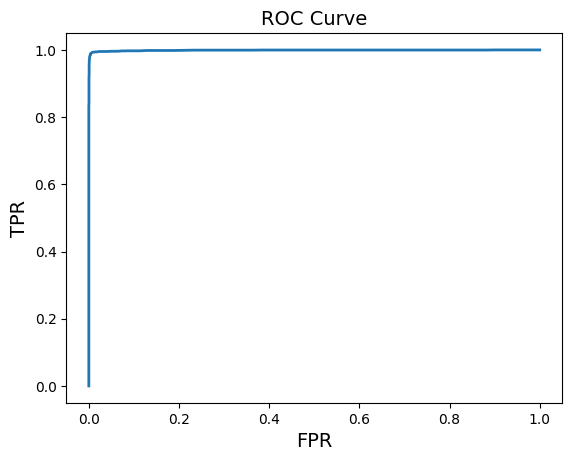


Confusion Matrix:
 [[2974   14]
 [  30 2969]]

Classification Report:
               precision    recall  f1-score   support

   Different       0.99      1.00      0.99      2988
        Same       1.00      0.99      0.99      2999

    accuracy                           0.99      5987
   macro avg       0.99      0.99      0.99      5987
weighted avg       0.99      0.99      0.99      5987



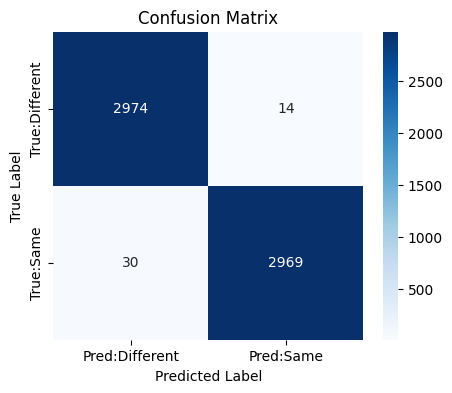

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import cv2
import io
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#  config dictionary
config = {
    "pretrained_path": "/kaggle/working/resnet18_110.pth",  # Path to pretrained model weights
    "model_type": "resnet18",                               # Can later add options like "edgeface", etc.
    "use_se": False,                                        # Whether to use Squeeze-Excitation blocks
    "grayscale": True,                                      # Process images in grayscale (True) or color (False)
    "image_size": 128,                                      # Input image size (width, height)
    "batch_size": 64,                                       # Batch size for evaluation (if needed)
    "data_root": "/kaggle/working/align/lfw-align-128",     # Root directory of processed images
    "pairs_file": "/kaggle/working/lfw_test_pair.txt",      # File with image pair information
    "embedding_size": 512,                                  # Expected embedding dimension from the model
    "nrof_folds": 10,                                       # Number of folds for ROC evaluation
    "threshold_range": (0, 3, 0.01)                         # (start, stop, step) for threshold sweep
}


# Model Definition (ResNetFace)
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class IRBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)
    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.prelu(out)
        return out

class ResNetFace(nn.Module):
    def __init__(self, block, layers, use_se=True, grayscale=True):
        super(ResNetFace, self).__init__()
        self.inplanes = 64
        in_ch = 1 if grayscale else 3
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        # For 128x128 input, final feature map will be 8x8
        self.fc5 = nn.Linear(512 * 8 * 8, config["embedding_size"])
        self.bn5 = nn.BatchNorm1d(config["embedding_size"])
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=config["use_se"]))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=config["use_se"]))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.bn5(x)
        return {'fea': x}

def resnet_face18(use_se=True, grayscale=True):
    return ResNetFace(IRBlock, [2, 2, 2, 2], use_se=use_se, grayscale=grayscale)


# Model Loader Class
class FaceModelLoader:
    def __init__(self, config, device):
        self.config = config
        self.device = device

    def load_model(self):
        if self.config["model_type"] == "resnet18":
            # Load the ResNetFace model with pretrained weights
            model = resnet_face18(use_se=self.config["use_se"], grayscale=self.config["grayscale"]).to(self.device)
            state_dict = torch.load(self.config["pretrained_path"], map_location=self.device)
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                new_key = k.replace("module.", "")
                new_state_dict[new_key] = v
            model.load_state_dict(new_state_dict)
            model.eval()
            return model
        # You can add other model types here (e.g., edgeface) based on self.config["model_type"]
        else:
            raise ValueError("Unsupported model type: {}".format(self.config["model_type"]))


# Image Processor Class
class ImageProcessor:
    def __init__(self, config):
        self.config = config

    def process_img(self, img_path):
        """Loads and preprocesses an image."""
        grayscale = self.config["grayscale"]
        size = self.config["image_size"]
        img = cv2.imread(img_path, 0) if grayscale else cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image at: {img_path}")
        img = cv2.resize(img, (size, size))
        if grayscale:
            img = img.reshape((size, size, 1))
        img = img.transpose((2, 0, 1)).astype(np.float32)
        # Scale pixel values to [-1, 1]
        img = (img - 127.5) / 127.5
        return torch.from_numpy(img).float()


# Evaluator Class
class FaceModelEvaluator:
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        self.img_processor = ImageProcessor(config)
        self.embedding_size = config["embedding_size"]

    def extract_embeddings(self):
        """Reads the pairs file and extracts embeddings for each image pair."""
        with open(self.config["pairs_file"], 'r') as fd:
            lines = fd.readlines()
        N = len(lines)
        embeddings = np.zeros([2 * N, self.embedding_size], dtype=np.float32)
        issame = []
        idx = 0
        for line in lines:
            line = line.strip()
            splits = line.split()
            if len(splits) < 3:
                print(f"Skipping line: {line}")
                continue
            # Build full image paths
            pathA = os.path.join(self.config["data_root"], splits[0].lstrip('/'))
            pathB = os.path.join(self.config["data_root"], splits[1].lstrip('/'))
            label = float(splits[2])
            # Process images using the ImageProcessor
            imgA = self.img_processor.process_img(pathA).unsqueeze(0)
            imgB = self.img_processor.process_img(pathB).unsqueeze(0)
            inputs = torch.cat([imgA, imgB], dim=0).to(self.device)
            with torch.no_grad():
                out_dict = self.model(inputs)
                out_np = out_dict['fea'].cpu().numpy()
            embeddings[2 * idx] = out_np[0]
            embeddings[2 * idx + 1] = out_np[1]
            issame.append(label)
            idx += 1

        # Trim to actual number of pairs and normalize embeddings
        embeddings = embeddings[:2 * idx]
        issame = issame[:idx]
        embeddings = normalize(embeddings)
        return embeddings, issame

    def calculate_accuracy(self, threshold, dist, actual_issame):
        predict_issame = np.less(dist, threshold)
        tp = np.sum(np.logical_and(predict_issame, actual_issame))
        fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
        tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
        fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
        tpr = 0 if (tp + fn == 0) else float(tp) / (tp + fn)
        fpr = 0 if (fp + tn == 0) else float(fp) / (fp + tn)
        acc = float(tp + tn) / dist.size
        return tpr, fpr, acc

    def calculate_roc(self, thresholds, embeddings1, embeddings2, actual_issame):
        k_fold = KFold(n_splits=self.config["nrof_folds"], shuffle=False)
        nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
        tprs = np.zeros((self.config["nrof_folds"], len(thresholds)))
        fprs = np.zeros((self.config["nrof_folds"], len(thresholds)))
        accuracy = np.zeros(self.config["nrof_folds"])
        best_thresholds = np.zeros(self.config["nrof_folds"])
        diff = embeddings1 - embeddings2
        dist = np.sum(np.square(diff), axis=1)
        indices = np.arange(nrof_pairs)
        for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
            acc_train = np.zeros(len(thresholds))
            for t_idx, threshold in enumerate(thresholds):
                _, _, acc_train[t_idx] = self.calculate_accuracy(threshold, dist[train_set], np.asarray(actual_issame)[train_set])
            best_threshold_index = np.argmax(acc_train)
            best_thresholds[fold_idx] = thresholds[best_threshold_index]
            for t_idx, threshold in enumerate(thresholds):
                tprs[fold_idx, t_idx], fprs[fold_idx, t_idx], _ = self.calculate_accuracy(threshold, dist[test_set], np.asarray(actual_issame)[test_set])
            _, _, accuracy[fold_idx] = self.calculate_accuracy(thresholds[best_threshold_index], dist[test_set], np.asarray(actual_issame)[test_set])
        return np.mean(tprs, axis=0), np.mean(fprs, axis=0), accuracy, best_thresholds

    def evaluate(self):
        # Extract embeddings from the pairs file
        embeddings, issame = self.extract_embeddings()
        thresholds = np.arange(*self.config["threshold_range"])
        embeddings1 = embeddings[0::2]
        embeddings2 = embeddings[1::2]
        tpr, fpr, accuracy, best_thresholds = self.calculate_roc(thresholds, embeddings1, embeddings2, issame)
        mean_acc = accuracy.mean()
        std_acc = accuracy.std()
        best_thresh = best_thresholds.mean()
        print(f"[Evaluation] #pairs = {len(issame)}")
        print(f"Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        print(f"Best threshold: {best_thresh:.4f}")

        # Plot ROC curve
        self.gen_plot(fpr, tpr)

        # Compute and display confusion matrix
        diff = embeddings1 - embeddings2
        dist = np.sum(np.square(diff), axis=1)
        y_true = np.array(issame, dtype=bool)
        y_pred = dist < best_thresh
        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:\n", cm)
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Different", "Same"]))
        self.plot_confusion_matrix(cm)
        return mean_acc, std_acc, best_thresh

    def gen_plot(self, fpr, tpr):
        plt.figure()
        plt.xlabel("FPR", fontsize=14)
        plt.ylabel("TPR", fontsize=14)
        plt.title("ROC Curve", fontsize=14)
        plt.plot(fpr, tpr, linewidth=2)
        plt.show()

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pred:Different", "Pred:Same"],
                    yticklabels=["True:Different", "True:Same"])
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()


if __name__ == "__main__":
    # Choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model using the FaceModelLoader class
    model_loader = FaceModelLoader(config, device)
    model = model_loader.load_model()
    
    # Create evaluator and run evaluation
    evaluator = FaceModelEvaluator(model, config, device)
    evaluator.evaluate()